**Welcome and Introduction**

Thank you for taking the time to explore this project, which evaluates two distinct datasets: *Company Bankruptcy Prediction* and *Amazon Fine Food Reviews*. Through the application of machine learning processes, we aim to uncover valuable insights that would otherwise remain hidden. This project highlights the power of three key methodologies: **Supervised Learning**, **Unsupervised Learning**, and **Natural Language Processing**, showcasing their potential to drive informed decision-making and strategic innovation.

### Unveiling Patterns: Unsupervised Learning on the Company Bankruptcy Prediction Dataset


In this section, we utilize **Unsupervised Learning** techniques to the *Company Bankruptcy Prediction* dataset, aiming to discover hidden patterns and underlying structures within the data. By leveraging methods such as **clustering** and **dimentionality reduction**, we strive to uncover insights that could help stakeholders identify key risk factors, group companies based on shared characteristics, and better understand the variables contributing to bankruptcy likelihood.

**Importing Libraries and our Company Bankruptcy Dataset**

In [189]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import scipy.stats
from sklearn.decomposition import PCA

df = pd.read_csv('bankruptcyPredictionData.csv') 


**Data Cleaning and Preprocessing**

Before diving into **unsupervised learning**, we first need to ensure the dataset is ready for analysis by performing essential data cleaning steps. This includes:
* **Removing duplicates** to avoid redundant information.
* **Checking for and handling missing values** to maintain data integrity.

Additionally, we drop the output variable (i.e the label). But why is this necessary? 

Since this analysis focuses on **unsupervised learning**, including the label could introduce bias into the dataset and distort the clustering or pattern discovery processes. By excluding the label, we ensure that our results are objective and genuinely reflective of the inherent structure of the data.

In [190]:
df = df.drop_duplicates()
df = df.drop(columns='Bankrupt?')
missing_values = pd.DataFrame({
    "Feature": df.columns,
    "Missing Values": df.isnull().sum().values
})

# Display as a formatted table
print('                 ### Dataset Features and Missing Values ###\n')
print(missing_values.to_markdown(index=False))

# Normalizes the data 
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

                 ### Dataset Features and Missing Values ###

| Feature                                                 |   Missing Values |
|:--------------------------------------------------------|-----------------:|
| ROA(C) before interest and depreciation before interest |                0 |
| ROA(A) before interest and % after tax                  |                0 |
| ROA(B) before interest and depreciation after tax       |                0 |
| Operating Gross Margin                                  |                0 |
| Realized Sales Gross Margin                             |                0 |
| Operating Profit Rate                                   |                0 |
| Pre-tax net Interest Rate                               |                0 |
| After-tax net Interest Rate                             |                0 |
| Non-industry income and expenditure/revenue             |                0 |
| Continuous interest rate (after tax)                    |          

**Determining the Optimal Number of Clusters with Elbow Plot and Silhoutte Score**

In [192]:
def optimalK(scaled, k_range=None):
    if not k_range:
        k_range = range(2, 11)
    inertias = []
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, n_init='auto' , random_state=42)
        kmeans.fit(scaled)
        inertias.append(kmeans.inertia_) #Sum of squared distances
        labels = kmeans.labels_     # Predict cluster labels
        score = silhouette_score(scaled, labels)
        silhouette_scores.append(score)
    plt.figure(figsize=(10, 4))
    #elbow plot
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, 'o-', label='Inertia')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Plot')
    #silhouette score plot
    plt.subplot(1, 2, 2)
    plt.bar(k_range, silhouette_scores, color='blue', label='Silhouette Score')
    plt.axhline(y=np.mean(silhouette_scores), color='red', linestyle='--', label='Mean Silhouette Score')
    plt.legend(loc='best')
    plt.ylim([0,1])
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Plot')
    plt.tight_layout()
    plt.show()


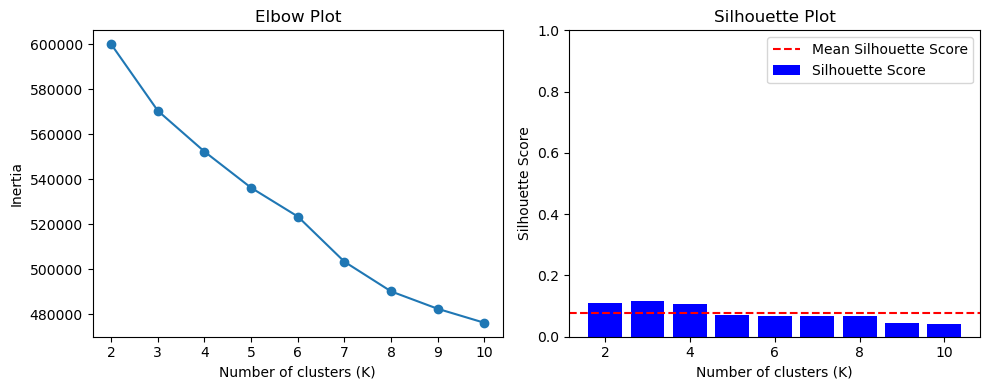

In [193]:
# Calling OptimalK function which will print out two charts, the Silhouettte Plot and Elbow Plot
optimalK(scaled)

Based on the graphs above, we observe a sharp decline in inertia between clusters 2 and 3, indicating that the optimal number of clusters could be in this range. Additionally, the silhouette plot shows that both **k=2** and **k=3** yield values above the average, suggesting these are viable options for the number of clusters. Given these observations, we will consider **k=2** or **k=3**. We have chosen to proceed with **k=2**.

Performing Centroid Analysis and Cluster Profiling

In [194]:
kmeans = KMeans(n_clusters=2, n_init='auto', random_state=42)
kmeans.fit(scaled)  
def centroidAnalysis(df, kmeans):
    centroid_means = kmeans.cluster_centers_
    within_cluster_variances = []
    for i in range(kmeans.n_clusters):
        cluster_data = df[kmeans.labels_ == i]  
        variances = np.var(cluster_data, axis=0)
        within_cluster_variances.append(variances)
    feature_names = df.columns.tolist()
    for i in range(kmeans.n_clusters):  # Loop through each cluster
        plt.figure(figsize=(14, 5 * kmeans.n_clusters))
        centroids = centroid_means[i]
        variances = within_cluster_variances[i]
        x_values = np.linspace(np.min(centroids) - 3, np.max(centroids) + 3, 100)
        for j in range(len(centroids)):
            plt.plot(x_values, scipy.stats.norm.pdf(x_values, centroids[j], np.sqrt(variances[j])), label=f'{feature_names[j]}') # Use feature names for labels
        plt.title(f'Cluster {i+1} Distributions')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend(loc='upper right', prop={'size': 6}) 
    plt.tight_layout()
    plt.show()

/Users/mattodinsky/opt/anaconda3/envs/bus390/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


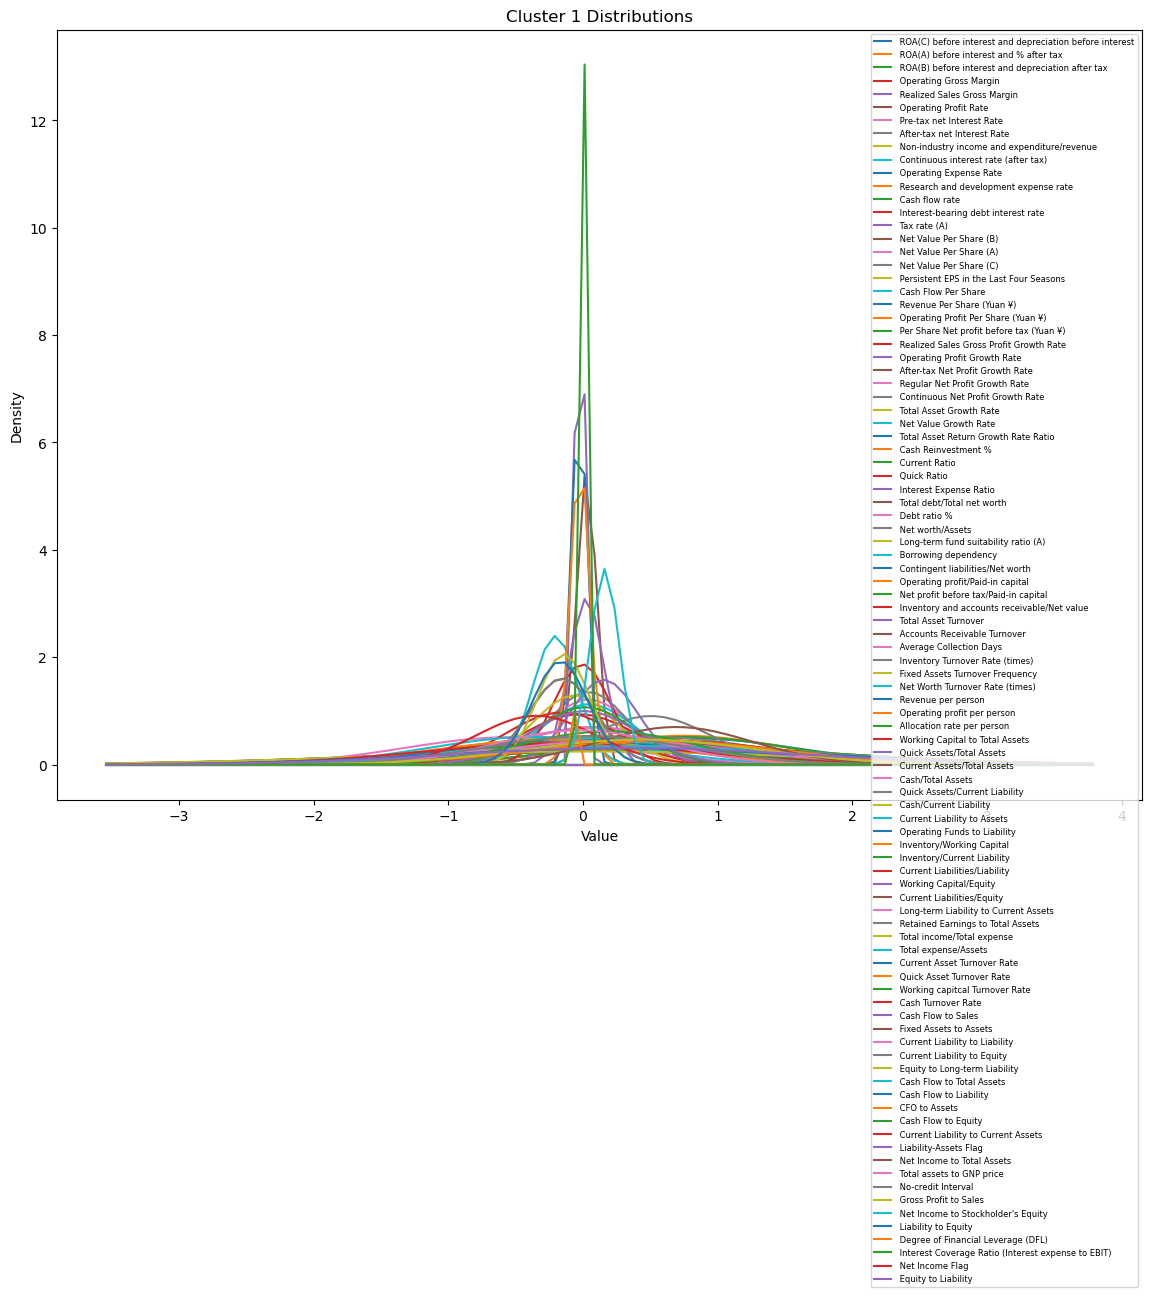

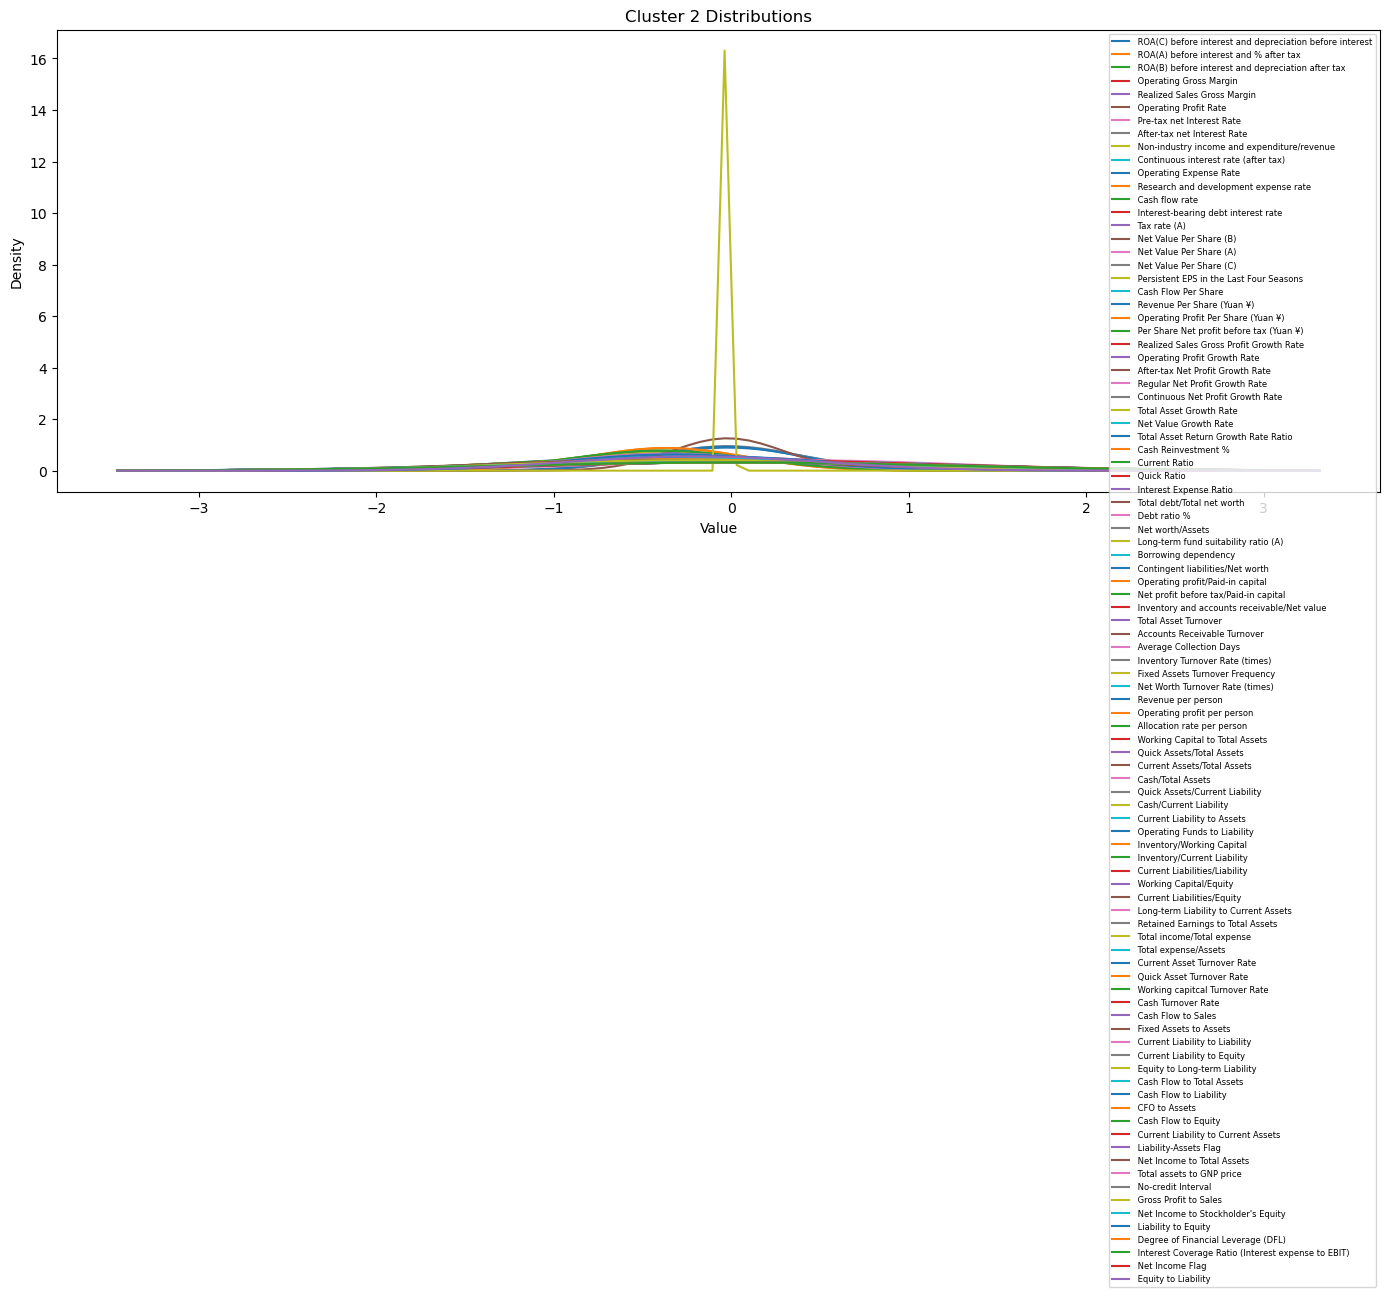

In [195]:
centroidAnalysis(pd.DataFrame(scaled, columns=df.columns), kmeans)

Due to the large number of features, it is difficult to draw meaningful insights from the cluster distribution graphs. To address this, we need to reduce the dimensionality while preserving the most significant variations in the data. For this purpose, we chose Principal Component Analysis (PCA). Consequently, we will rerun K-Means clustering on the PCA-transformed data and conduct the cluster analysis and profiling again.

In [196]:
pca = PCA(n_components=0.9)  # Retain 90% of the variance
scaled_pca = pca.fit_transform(scaled)
print(f"From PCA the number of components retained: {pca.n_components_}")

From PCA the number of components retained: 45


**Determining Optimal K for clustering after PCA Dimentionality Reduction**

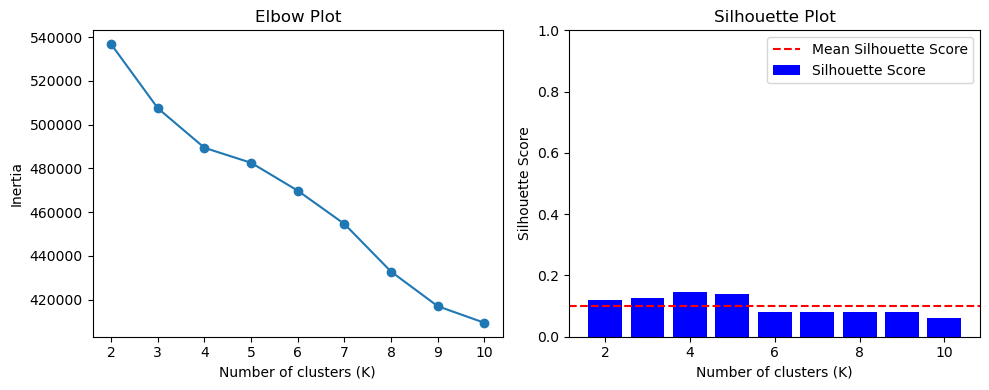

In [197]:
optimalK(scaled_pca)

The graphs indicate a significant drop in inertia between clusters 2, 3, and 4, suggesting that the optimal number of clusters lies within this range. Furthermore, the silhouette plot shows that **k=2**, **k=3**, and **k=4** all have values above the average, making these configurations viable candidates for the number of clusters. As a result, we will continue using **k=2** as our number of clusters.

**Performing Centroid Analysis on our Dimension Reduced dataset**

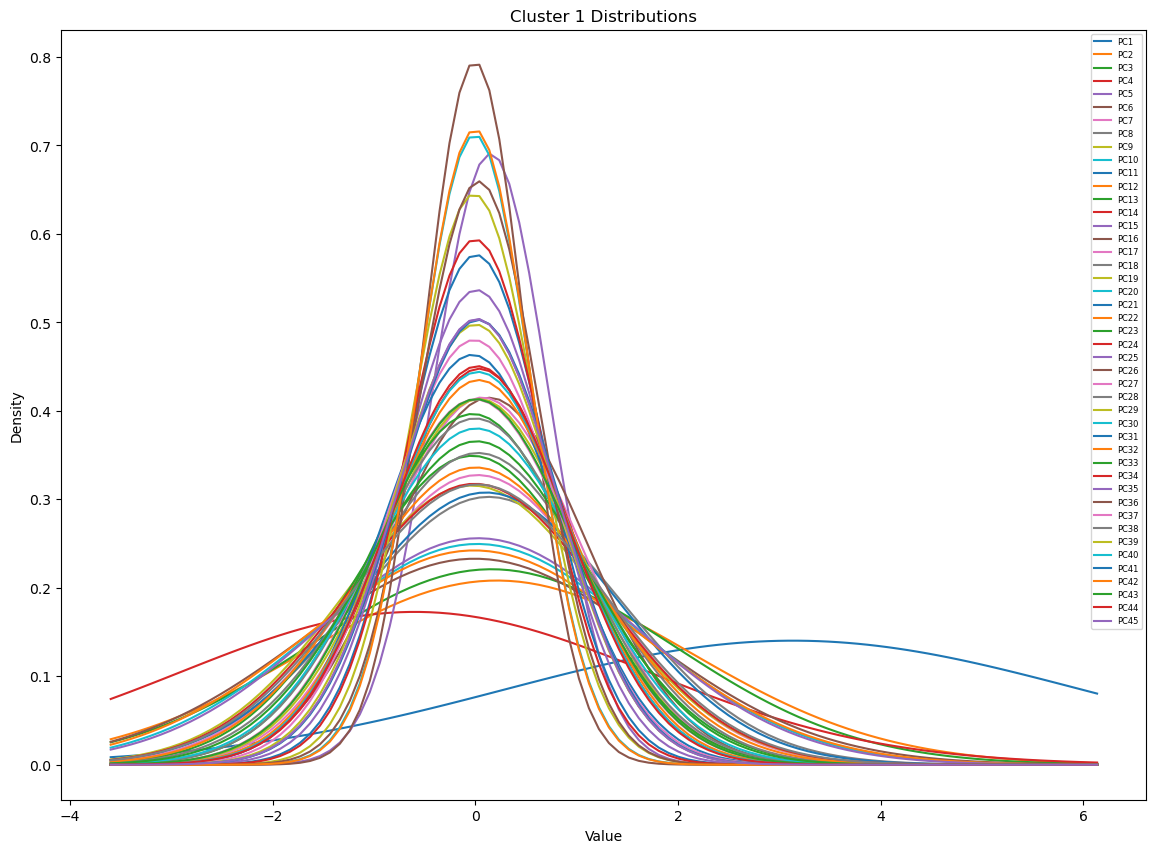

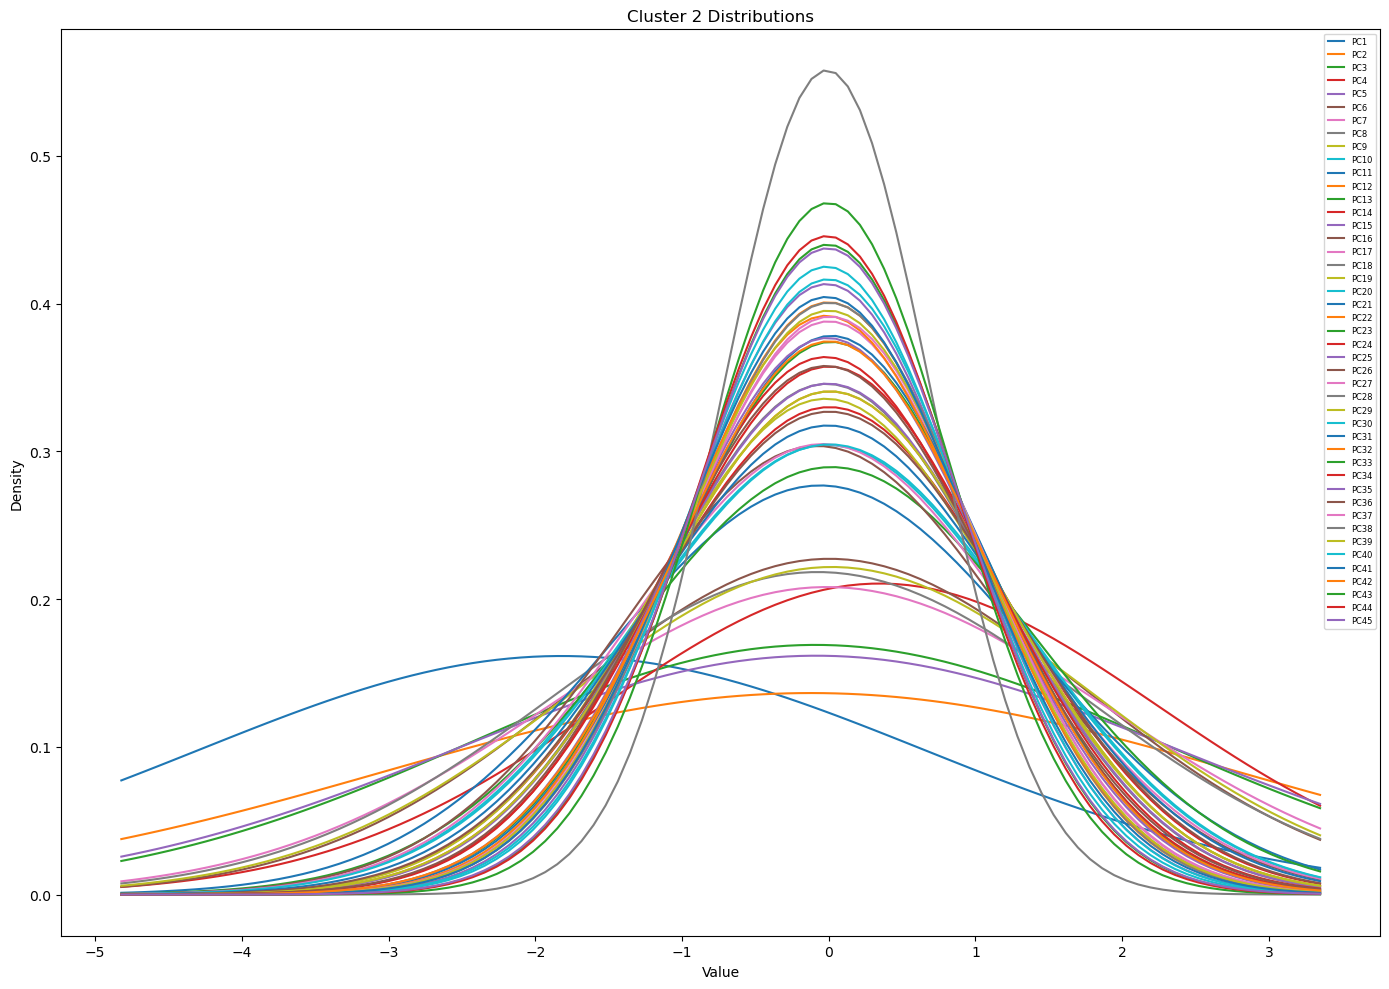

In [208]:
kmeans = KMeans(n_clusters=2, n_init='auto', random_state=42)
kmeans.fit(scaled_pca) 
pca_column_names = [f'PC{i+1}' for i in range(scaled_pca.shape[1])]
centroidAnalysis(pd.DataFrame(scaled_pca, columns=pca_column_names), kmeans)


**Cluster 1 Distributions**
- **Description**
    - This density plot illustrates the distribution of 45 principal components for a specific cluster (Cluster 1).
    - Each line corresponds to the density of values for a principal component within this cluster.
- **Key Insights**
    1. **Centralized Distribution:**
        - Most distributions are sharply peaked, with high density concentrated around a central value.
        - This indicates low variability and a homogeneity of features within Cluster 1.
    2. **Outliers in Component**
        - Certain components, such as PC1, show a broader distribution compared to others. 
        - These variations could signal areas of divergence in underlying financial or operational performance for the entities in this cluster.
    3. **Cluster Stability**
        - The overall uniformity in most distributions suggests Cluster 1 represents a group of entities with similar financial profiles.
- **Business Implications**
    - The uniformity observed within Cluster 1 suggests opportunities for targeted strategies, such as standardized financial solutions or operational adjustments, to potentially mitigate risks associated with bankruptcy.
    - Broader components like PC1 and PC40 warrant deeper investigation, as they might highlight outlier behaviors or key factors linked to financial distress or opportunities for proactive intervention.
    - This analysis can inform segmentation strategies that enable tailored actions to address varying levels of financial risk and support early identification of companies at risk of bankruptcy.



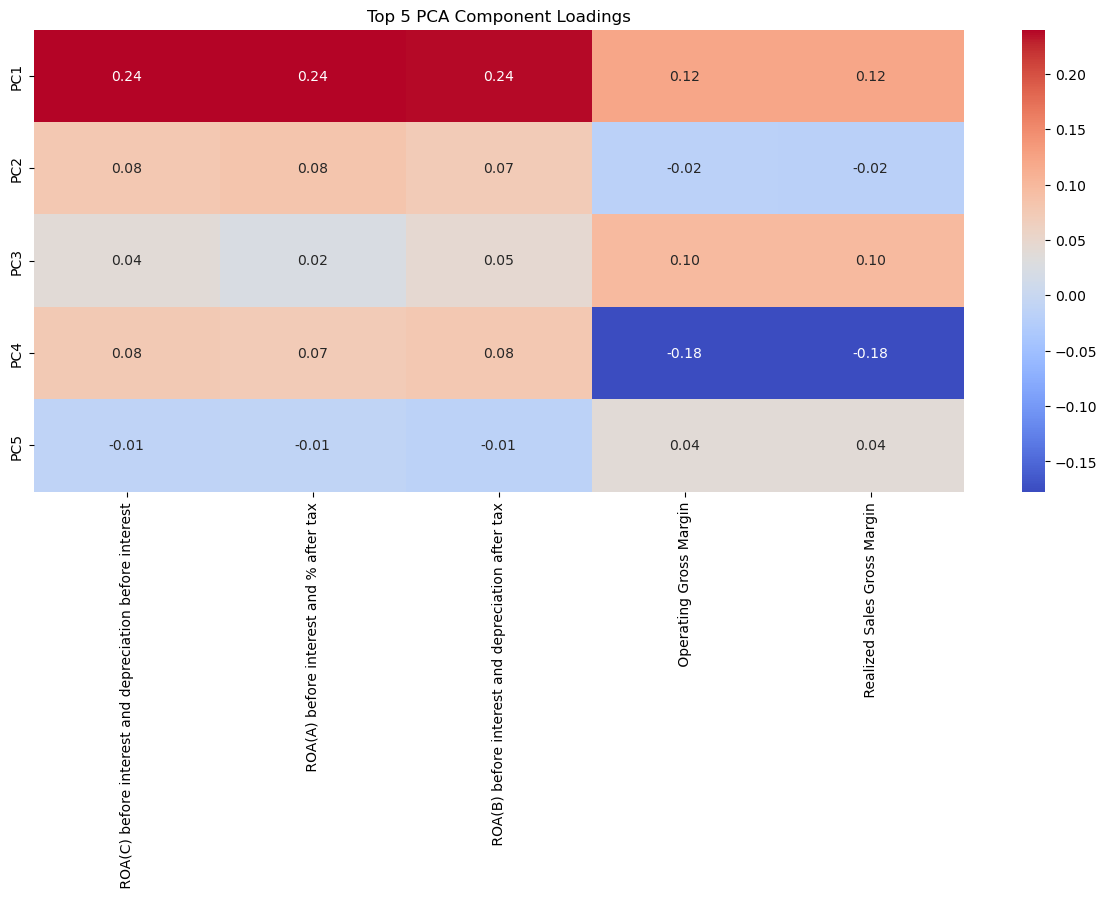

In [207]:
pca_components_df = pd.DataFrame(
    pca.components_,
    columns=df.columns, 
    index=pca_column_names  
)
import seaborn as sns
top_components = pca_components_df.iloc[:5, :5]
plt.figure(figsize=(15, 6))
sns.heatmap(top_components, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Top 5 PCA Component Loadings")
plt.show()
centroids_pca = kmeans.cluster_centers_

**Analysis of the Top 5 PCA Component Loadings**
- **Description**
    - This heatmap displays the loadings of the top five principal components (PC1 to PC5) against selected financial metrics or features.
    - Each cell represents the degree of contribution (positive or negative) of a particular feature to a principal component.
- **Insights**
    1. **Dominance of ROA related metrics in PC1:**
        - PC1 is heavily influenced by three return-on-assets (ROA) metrics, each with a loading of **0.24**.
        - This suggests that profitability-related metrics before interest and depreciation are significant drivers of overall financial variation.
    2. **Contrasting Contributions in PC4:**
        - "Operating Gross Margin" and "Realized Sales Gross Margin" exhibit negative contributions **(-0.18 each)** in PC4.
        - These negative loadings possibly indicate a trade-off or opposing trends between profitability and operational metrics in this component.
- **Business Implications**
    - The prominent influence of ROA metrics underscores the importance of focusing on profitability as a key strategy for minimizing bankruptcy risk. 
    - The negative contributions of operational and sales margins in PC4 warrant further investigation into cost structures and revenue management strategies to balance operational efficiency and profitability.


Now we want to reconstruct the data from PCA following more closely to the original dataframe

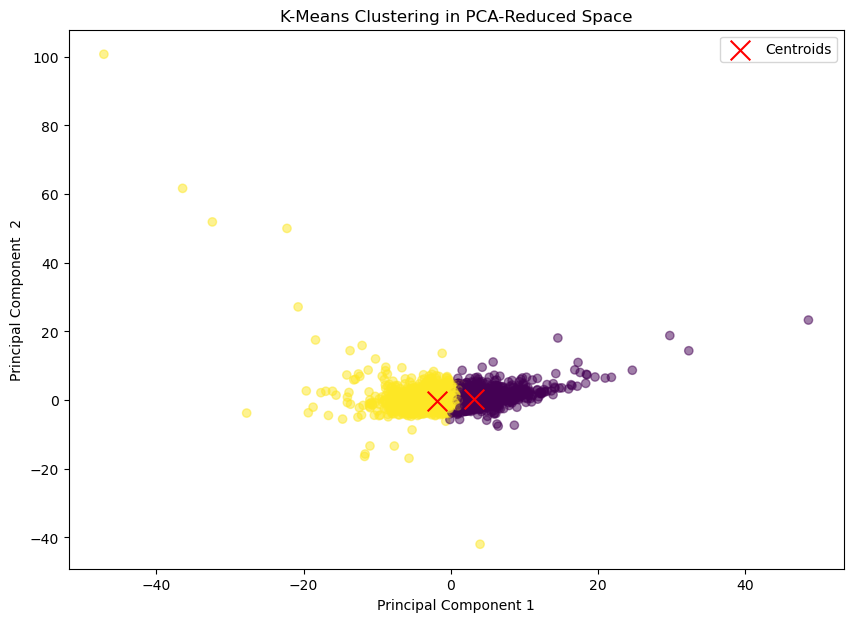

In [199]:
plt.figure(figsize=(10, 7))
plt.scatter(scaled_pca[:, 0], scaled_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title('K-Means Clustering in PCA-Reduced Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component  2')
plt.legend()
plt.show()

**Analysis of Clustering Plot**
* The cluster plot displays the results of the KMeans clustering on reconstructed PCA data. 
* Each point in the plot corresponds to a data sample. 
* The points are grouped into 3 main clusters, centered about the origin. Each color represents a different cluster, with its centroid (mean value) marked by the red 'X'.
* The clusters are for the most compact, aside from some outliers 

reconstructed_scale shape: (6819, 95)
reconstructed_centroids_scale shape: (6819, 95)
kmeans.labels_ shape: (6819,)


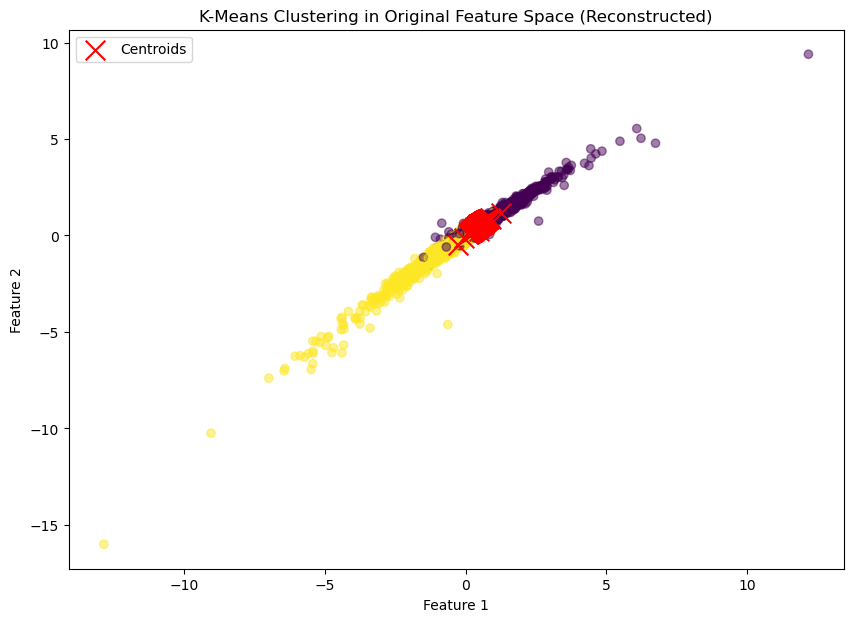

In [ ]:
reconstructed = pca.inverse_transform(scaled_pca)
reconstructed_scale = scaler.inverse_transform(reconstructed)
plt.figure(figsize=(10, 7))
plt.scatter(
    reconstructed[:, 0],  
    reconstructed[:, 1], 
    c=kmeans.labels_,          
    cmap='viridis', 
    alpha=0.5
)

# Scatter plot for centroids
plt.scatter(
    reconstructed_scale[:, 0],  
    reconstructed_scale[:, 1],  
    c='red',                            
    marker='x', 
    s=200, 
    label='Centroids'
)
plt.title('K-Means Clustering in Original Feature Space (Reconstructed)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')  # Replace with actual feature names if needed
plt.legend()
plt.show()


### Implementing Supervised Learning for Prediction

#### **Focus on Key Financial Indicator: Operating Gross Margin**
In analyzing the Company Bankruptcy Prediction dataset, we encounter a variety of financial metrics, each contributing valuable insights. However, for the purposes of our Supervised Learning analysis, we will focus on one critical metric: **Operating Gross Margin**.

**Why Choose the Operating Gross Margin?**
Operating Gross Margin is a key indicator of a company's profitability and operational efficiency, specifically reflecting the percentage of revenue left after deducting the cost of goods sold. This ratio is crucial for understanding the financial health of a company as it highlights how well the company generates revenue from direct costs, excluding other operational expenses. Moreover, it serves as an essential metric for assessing a company's ability to withstand economic fluctuations:
1. Profitability: 
- A higher Operating Gross Margin suggests that a greater portion of revenue is retained after covering direct production costs, which enhances profitability. This enables the company to:
    * Allocate more funds for reinvestment into business expansion, technology upgrades, and innovation.
    * Maintain financial stability and flexibility by covering other operating expenses, such as marketing, salaries, and research.
2. Operational Efficiency: 
- A lower Operating Gross Margin can indicate inefficiencies in production or increasing costs that may erode profitability. Such issues might result from:
    * Increased cost of raw materials or labor.
    * Inability to pass on rising costs to consumers.
    * Operational inefficiencies within the company’s business model.
3. Financial Resilience:
- The Operating Gross Margin also serves as a measure of the company's ability to absorb external financial pressures, such as rising input costs or economic downturns. A healthy margin strengthens the company's capacity to withstand adverse market conditions, whereas a declining margin might signal underlying operational or financial weaknesses.




**Importing our Libraries and our Dataset**

In [139]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from scipy.stats import zscore
df = pd.read_csv('bankruptcyPredictionData.csv') 


**Data Cleaning and Preprocessing**

As previously noted, our dataset does not contain any missing values. However, when preparing for supervised learning, additional data cleaning steps are necessary to ensure that the dataset is properly formatted and free of inconsistencies.

1. **Removing Duplicates**
* First, we eliminate any duplicate rows from the dataset to avoid redundancy and to prevent skewed results during out model training.
2. **Feature Selection**
* Since our task is to predict **Operational Gross Margin**, we remove it from our dataset (X) assigning it to the target variable (Y). This ensures that the model can learn to predict the target from the other features in the dataset .
3. **Encoding** 
* We apply an encoding on categorical variables within our dataset, making them more suitable for machine learning processes.
4. **Correlation Handling**
* High correlations between features can lead to multicollinearity, which might affect model performance. To address this, we calculate the correlation matrix and identify pairs of features with a correlation greater than 0.9. We drop one of the features from each highly correlated pair to ensure we’re not overfitting or introducing unnecessary redundancy.
5. **Outlier Handling***
* Outliers can skew the performance of our models. We are removing these outliers from both the feature set and the target variable.

Additionally, scaling the data is a crucial preprocessing step. By standardizing the features, we ensure that all variables are on a comparable scale, preventing features with larger numerical ranges from dominating the model's learning process. This allows the model to learn more effectively without any feature disproportionately influencing the outcome.

It is important to note that scaling is performed separately on the training, validation, and test sets. We first fit the scaler on the training data, then apply the same transformation to the validation and test sets. This ensures that the model is evaluated on data scaled in the same manner as the training data, avoiding data leakage and ensuring unbiased results.

In [140]:
df = df.drop_duplicates()
X = df.drop(columns=[' Operating Gross Margin']) 
X = pd.get_dummies(X, drop_first=True)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X = X.drop(columns=to_drop)
z_scores = np.abs(zscore(X.select_dtypes(include=[np.number])))  
outliers_zscore = (z_scores > 3)
clean_indices = ~outliers_zscore.any(axis=1)
X_cleaned= X[~clean_indices]


Y = df[' Operating Gross Margin'] 
Y_cleaned= Y[~clean_indices]

In [153]:
X_train, Xt, Y_train, Yt = train_test_split(X_cleaned, Y_cleaned, test_size=0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(Xt, Yt, test_size=0.5, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training data
X_val_scaled = scaler.transform(X_val)      # Fit and transform validation set
X_test_scaled = scaler.transform(X_test)        # Fit and transform test set

scaler_y = StandardScaler()
Y_train_scaled = scaler_y.fit_transform(Y_train.values.reshape(-1, 1))
Y_val_scaled = scaler_y.transform(Y_val.values.reshape(-1, 1))
Y_test_scaled = scaler_y.transform(Y_test.values.reshape(-1, 1))

In [154]:
alphas=[0.000001, 0.00005, 0.0001, 0.001, 0.005, 0.01, 0.1, 0.5, 0.9]
r  = []
print("Determining Optimal Alpha Value: ")
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=5000, fit_intercept=True)
    lasso.fit(X_train_scaled, Y_train_scaled)  
    pred = lasso.predict(X_val_scaled)  
    Y_val_pred = scaler_y.inverse_transform(pred.reshape(-1, 1))
    Y_val_original = scaler_y.inverse_transform(Y_val_scaled)
    mse = mean_squared_error(Y_val_original, Y_val_pred)
    r.append((a, mse))
    print(f"Alpha: {a} | MSE: {mse}")
r = sorted(r, key=lambda x: x[1])
bestAlpha = r[0][0]
print('Optimal Alpha Value: ', bestAlpha)

Determining Optimal Alpha Value: 


Alpha: 1e-06 | MSE: 2289858112476.351
Alpha: 5e-05 | MSE: 6153629783.578466
Alpha: 0.0001 | MSE: 979297634.4683151
Alpha: 0.001 | MSE: 1.4014939814947796e-06
Alpha: 0.005 | MSE: 1.4127867097250378e-06
Alpha: 0.01 | MSE: 1.4602166202273487e-06
Alpha: 0.1 | MSE: 9.465670628831901e-06
Alpha: 0.5 | MSE: 0.0002089912277938955
Alpha: 0.9 | MSE: 0.0006761833344630662
Optimal Alpha Value:  0.001


As determined by our function above, we are iterating through various alpha values, testing each as a parameter for the Lasso model trained on our training set. The objective here is to minimize our **Mean Squared Error** (MSE) value. The resulting optimal value for Alpha is **0.001**.

Performing Lasso Regression

In [155]:
lasso_reg = Lasso(alpha=bestAlpha, max_iter=10000, fit_intercept=True)
lasso_reg.fit(X_train_scaled, Y_train_scaled)
Y_val_pred_scaled = lasso_reg.predict(X_val_scaled)
Y_val_pred = scaler_y.inverse_transform(Y_val_pred_scaled.reshape(-1, 1))
Y_val_original = scaler_y.inverse_transform(Y_val_scaled)
mse = mean_squared_error(Y_val_original, Y_val_pred)
r2 = r2_score(Y_val_original, Y_val_pred)
print("Validation Mean Squared Error (MSE):", mse)
print("Validation R² Score:", r2)

Validation Mean Squared Error (MSE): 1.4014939814947796e-06
Validation R² Score: 0.9983205369940839


In [156]:
Y_test_pred_scaled = lasso_reg.predict(X_test_scaled) 
Y_test_pred = scaler_y.inverse_transform(Y_test_pred_scaled.reshape(-1, 1))
Y_test_original = scaler_y.inverse_transform(Y_test_scaled)
test_mse = mean_squared_error(Y_test_original, Y_test_pred)
test_r2 = r2_score(Y_test_original, Y_test_pred)

print("Test Mean Squared Error (MSE):", test_mse)
print("Test R² Score:", test_r2)

Test Mean Squared Error (MSE): 7.784948593043223e-07
Test R² Score: 0.9983442366642137


**Interpreting the Mean Squared Error (MSE) and R²**
- **Mean Squred Error (MSE)**
    - **Validation MSE**: 1.4015e-06
    - **Test MSE**: 7.7849e-07
    MSE measures the average squared difference between the predicted and actal values. A lower MSE indicates better performance of the model. The Test MSE here is significantly smaller that the Validation MSE. This suggets that the model is performing better on the Test set compared to the Validation set. However, the very small values of both MSEs indicate that the model's predictions are very close to the true values for both the validation and test sets.
- **R² Score**
    - **Validation R²**: 0.99832
    - **Test R²**: 0.99834
    The R² values speak on the success of the model in explaing the variance of the target (Operational Gross Margin). It is a value ranging from 0 and 1, where:
    - 1 means perfect predictions (the model explains all the variance).
    - 0 means the model does not explain the variability.
    The R² scores of our model (0.9990 for validation and 0.9989 for test) suggest that the model explains over 99% of the variance in the data.


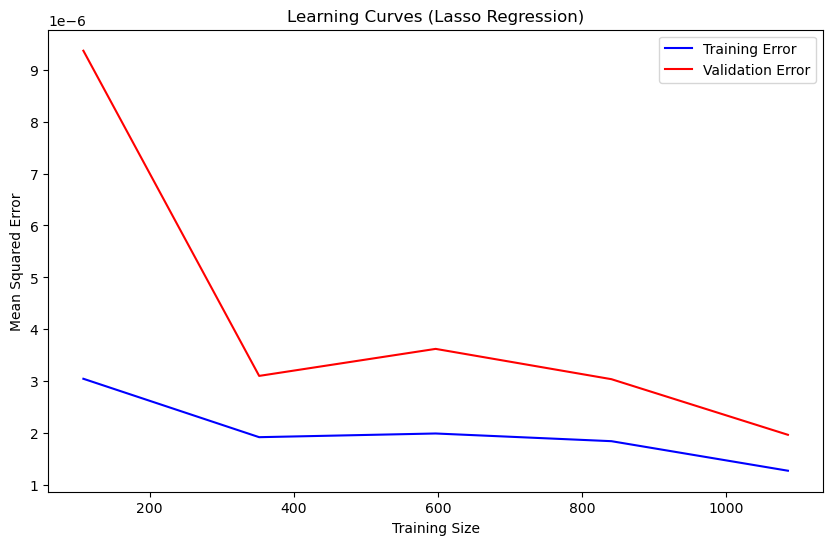

In [157]:
train_sizes, train_scores, val_scores = learning_curve(lasso_reg, X_train_scaled, Y_train, cv=10, scoring='neg_mean_squared_error')
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, -train_scores.mean(axis=1), label="Training Error", color='blue')
plt.plot(train_sizes, -val_scores.mean(axis=1), label="Validation Error", color='red')
plt.title("Learning Curves (Lasso Regression)")
plt.xlabel("Training Size")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

**Interpreting the Graph:**
- Initially, the validation error is higher than the training error. This can happen because the model is still adjusting to the larger training set, and it might take time for the model to adapt. As the model sees more data, its performance improves (validation error decreases). The slight increase in the middle may be due to the model experiencing more variability in the data. 
- After the slight increase, the validation error continues to decrease, as the model continues to improve with more training data.
- As the size of the training data increases, the training error continues to decrease suggesting that the model is fitting well with the training data.


### Natural Language Processing (NLP) on Amazon Fine Food Review Dataset
In this section, we utilize Natural Language Processing (NLP) techniques to analyze the Amazon Fine Food Review Dataset. The dataset, which contains over 500,000 product reviews, provides rich textual data allowing us to gain valuable insights into customer sentiments, preferences, and behaviors regarding food products. By leveraging NLP, we aim to process, clean, and extract meaningful information from its text data, enabling us to uncover hidden patterns and trends.

**Importing Libraries and our Food Review Dataset**

In [116]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
from nltk.corpus import stopwords
from joblib import Parallel, delayed
# nltk.download('stopwords')

df_reviews = pd.read_csv("Reviews.csv")
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None


**Sample Reviews**

In [ ]:
sample_articles = df_reviews.sample(6, random_state=42)[['ProductId','Score', 'Text']]
print("Sample Articles:")
display(sample_articles)

Sample Articles:


,ProductId,Score,Text
165256,B000EVG8J2,5,Having tried a couple of other brands of glute...
231465,B0000BXJIS,5,My cat loves these treats. If ever I can't fin...
427827,B008FHUFAU,3,A little less than I expected. It tends to ha...
433954,B006BXV14E,2,"First there was Frosted Mini-Wheats, in origin..."
70260,B007I7Z3Z0,5,and I want to congratulate the graphic artist ...
49866,B000FKMNSM,4,Please add more Pineapple flavor to your packa...


**Looking a little more in depth at some of the Articles above**

In [118]:
print(df_reviews.loc[165256])
text = df_reviews.loc[165256]['Text']
print('Review Text:', '\n'.join([text[i:i+100] for i in range(0, len(text), 100)]))

Id                                                                   165257
ProductId                                                        B000EVG8J2
UserId                                                       A1L01D2BD3RKVO
ProfileName                                          B. Miller "pet person"
HelpfulnessNumerator                                                      0
HelpfulnessDenominator                                                    0
Score                                                                     5
Time                                                             1268179200
Summary                        Crunchy & Good Gluten-Free Sandwich Cookies!
Text                      Having tried a couple of other brands of glute...
Name: 165256, dtype: object
Review Text: Having tried a couple of other brands of gluten-free sandwich cookies, these are the best of the bun
ch.  They're crunchy and true to the texture of the other "real" cookies that aren't gluten-free. 

In [119]:
print(df_reviews.loc[49866])
text = df_reviews.loc[49866]['Text']
print('Review Text:', '\n'.join([text[i:i+100] for i in range(0, len(text), 100)]))

Id                                                                    49867
ProductId                                                        B000FKMNSM
UserId                                                       A1XWK6ZWTW4C3B
ProfileName                                          Tammie Travis "//Tt//"
HelpfulnessNumerator                                                      3
HelpfulnessDenominator                                                    3
Score                                                                     4
Time                                                             1261958400
Summary                                       Lifesavers - Pineapple flavor
Text                      Please add more Pineapple flavor to your packa...
Name: 49866, dtype: object
Review Text: Please add more Pineapple flavor to your packages of lifesavers, in fact, can you sell pineapple fla
vor by itself?


**Data Cleaning and Preprocessing for Text Analysis**
In order to create an effective model that can accurately analyze and interpret textual data, we first need to ensure the data is clean, consistent, and free of any irrelevant or redundant information. The steps involve:
1. **Standardizing the Text Format**
- **Why it matters**: Inconsistent text formats can lead to confusion and inaccuracies in our analysis. By converting all text to lowercase, we ensure that the model treats similar words (e.g., "Amazon" vs. "amazon") as the same, avoiding any discrepancies that could impact results.
- **What do we do?** Convert all text to lowercase. 
2. **Removing Punctuation and Numbers**
- **Why it matters**: Punctuation marks and numbers are often unneeded in text analysis and can change the models understanding.
- **What do we do?** We remove them to make sure the focus lies with the meaningful words of the text.
3. **Eliminating Stopwords**
- **Why it matters**: Common words like "and", "the", or "is" don’t carry significant meaning in our analysis and can clutter the data.
- **What do we do?** We remove words using a predefined list of stopwords.
4. **Cleaning Extra Spaces**
- **Why it matters**: Extra spaces can interfere with the text's readability and consistency, affecting the model’s processing.
- **What do we do?** We remove unnecessary whitespace between words ensuring properly formatted text.
5. **Special Words and Custom Terms Handling**
- **Why it matters**: Sometimes, our dataset might contain specific terms or brand names that we consider irrelevant for the analysis (e.g., "Amazon", "br", or informal phrases). We identify these terms and remove them to prevent bias. Moreover, by viewing the word cloud graphs below, we can determine additional words fitting this category.
- **What do we do?** We update the stopwords set to include these words.

In [120]:
stop_words = set(stopwords.words('english'))
stop_words.update(['amazon', 'im', 'really', 'ive', 'br'])
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = ' '.join(text.split()) #Remove extra whitespace
    return text

**Parallel Cleaning for Efficiency**

Given the size of our dataset, cleaning the data sequentially (one row at a time) can be time-consuming. To address this, we can use parallel processing, a technique that allows us to perform multiple data cleaning tasks simultaneously, significantly speeding up the process.

- **How Parallel Processing Works**
* Parallel Function: A parallel function divides the task of cleaning text data into smaller chunks. Instead of cleaning one text entry at a time, multiple entries are processed concurrently across different computing resources (e.g., multiple cores or processors).
- **Random Sampling for Faster Results**
* Another strategy to speed up the cleaning process is random sampling. Instead of cleaning the entire dataset, we can take a smaller, random sample of the data to work with. This helps us get quicker insights without waiting for the entire dataset to be cleaned. 

By combining both **parallel processing** and **random sampling**, we can speed up cleaning spead and extract meaning from results more quickly. 


In [121]:
def parallel_clean(df, num_jobs=4):
    cleaned_text = Parallel(n_jobs=num_jobs)(
        delayed(clean_text)(text) for text in df['Text']
    )
    return cleaned_text

**Comparing Original Text with Their Respective Cleaned text**

To demonstrate the effectiveness of our text cleaning process, we’ve provided a comparison between the original and cleaned text below.

**Key Changes After Cleaning**
1. **Removal of Stopwords:** Common, irrelevant words such as "having", "and", and "there" have been removed. 
2. **Punctuation Removal:** We’ve removed punctuation marks such as hyphens and periods that can interfere with analysis.
3. **Lowercasing:** All words have been converted to lowercase. 

In [122]:
raw_text = df_reviews.sample(6, random_state=42)
cleaned_texts = parallel_clean(raw_text, num_jobs=4)
comparison_df = pd.DataFrame({
    'Original Text': raw_text['Text'].values,
    'Cleaned Text': cleaned_texts
})
print("Comparison of Original and Cleaned Texts:")
display(comparison_df)

Comparison of Original and Cleaned Texts:


,Original Text,Cleaned Text
0,Having tried a couple of other brands of glute...,tried couple brands glutenfree sandwich cookie...
1,My cat loves these treats. If ever I can't fin...,cat loves treats ever cant find house pop top ...
2,A little less than I expected. It tends to ha...,little less expected tends muddy taste expecte...
3,"First there was Frosted Mini-Wheats, in origin...",first frosted miniwheats original size frosted...
4,and I want to congratulate the graphic artist ...,want congratulate graphic artist putting entir...
5,Please add more Pineapple flavor to your packa...,please add pineapple flavor packages lifesaver...


**Performing Latent Dirichlet Allocation**

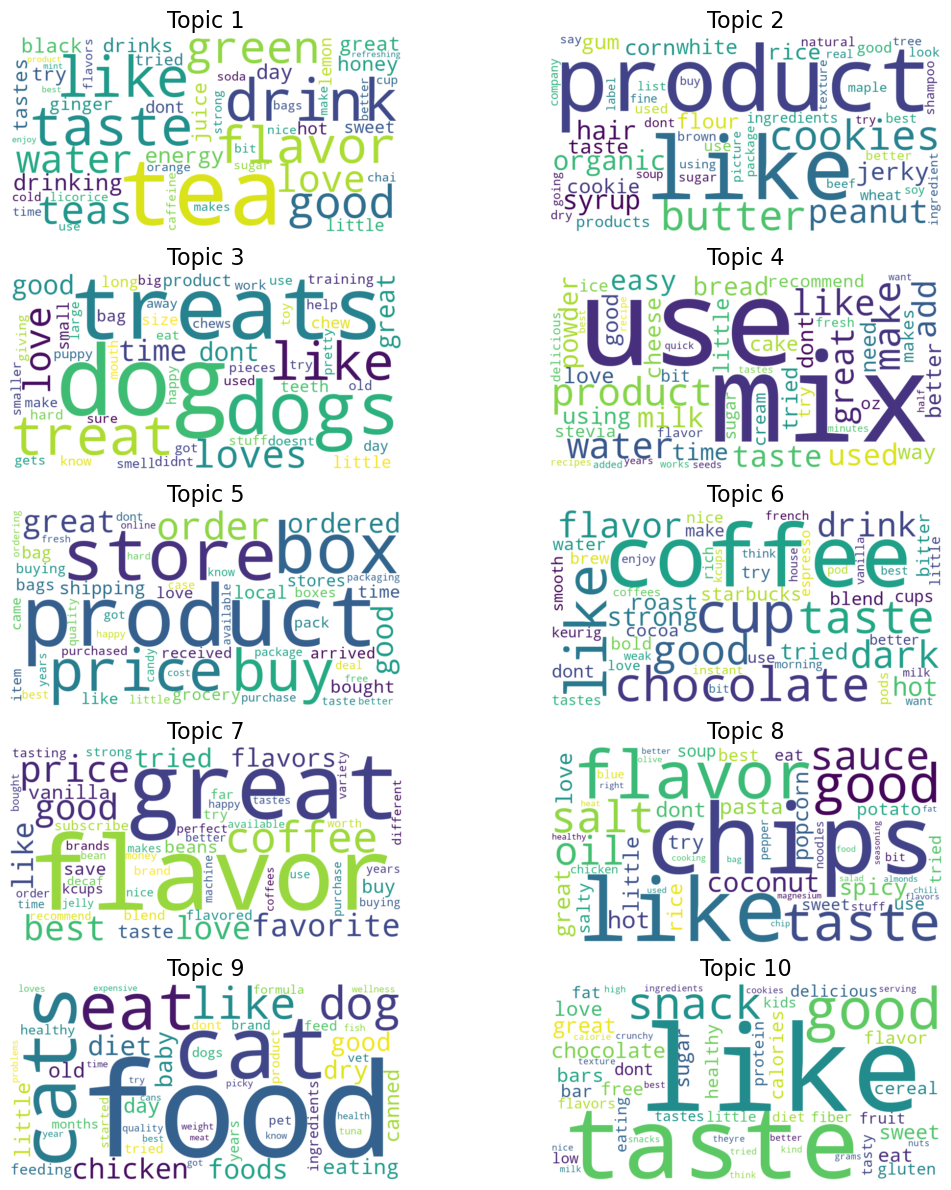

Top Words for Each Topic:


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,tea,drink,like,taste,flavor,good,green,teas,water,love
Topic 2,product,like,cookies,butter,peanut,organic,syrup,hair,jerky,rice
Topic 3,dog,treats,dogs,treat,like,loves,love,time,good,great
Topic 4,mix,use,product,make,water,like,great,add,taste,used
Topic 5,product,store,box,price,buy,order,great,good,ordered,shipping
Topic 6,coffee,like,cup,chocolate,taste,good,dark,flavor,drink,strong
Topic 7,flavor,great,coffee,price,good,best,love,favorite,like,tried
Topic 8,chips,like,flavor,taste,good,salt,sauce,oil,coconut,hot
Topic 9,food,cat,cats,eat,dog,like,chicken,diet,foods,dry
Topic 10,like,taste,good,snack,chocolate,great,sweet,love,sugar,bars


In [178]:
cleaned_text_sample = df_reviews.sample(n=10000, random_state=45)
cleaned_text = parallel_clean(cleaned_text_sample, num_jobs=4)

# Convert the cleaned text into a bag-of-words representation
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
text_bow = vectorizer.fit_transform(cleaned_text)

n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(text_bow)
feature_names = vectorizer.get_feature_names_out()
wordClouds = {}
def word_clouds(model, feature_names, n_topics):
    fig, axes = plt.subplots(5, 2, figsize=(12, 12))
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        word_weights = {feature_names[i]: topic[i] for i in topic.argsort()[:-50 - 1:-1]}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_weights)
        wordClouds[topic_idx] = wordcloud
        ax = axes[topic_idx]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f"Topic {topic_idx + 1}", fontsize=16)
    plt.tight_layout()
    plt.show()
word_clouds(lda_model, feature_names, n_topics)
def display_topics(model, feature_names, num_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics[f"Topic {topic_idx + 1}"] = top_words
    return topics

# Extract and display the top 10 words for each topic
topics = display_topics(lda_model, feature_names, 10)
topics_df = pd.DataFrame.from_dict(topics, orient='index', columns=[f"Word {i+1}" for i in range(10)])

print("Top Words for Each Topic:")
display(topics_df)


In [179]:
def get_wordcloud(i):
    wordcloud_image = wordClouds.get(i)
    
    if wordcloud_image:
        plt.subplots(figsize=(8, 4))
        plt.imshow(wordcloud_image, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    else:
        print(f"Word cloud for {i} does not exist.")

**Analyzing WordClouds**

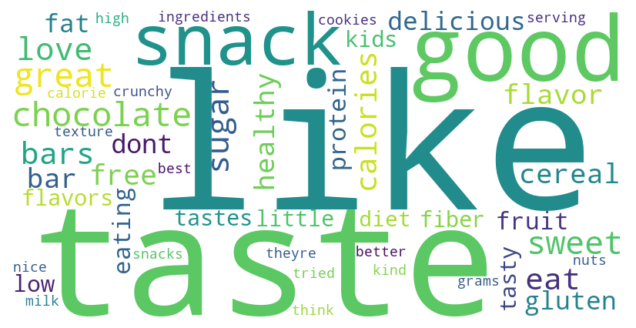

In [183]:
get_wordcloud(9) #Values ranging from 0 to 9

**Topic 10: Snacks**
- **Supporting Evidence:**
    - **Keywords Identified:** 'snack,' 'chocolate,' 'bars,' 'fiber', and 'protein.'
    - These terms support the interpretation that this topic is associated with snacks and snack-related products. The word 'snack' is a clear indicator of this category, while 'chocolate' and 'bars' point to popular snack types, particularly in the context of sweets and convenience food.
    - **Health-Conscious Products:** The presence of 'protein', 'fiber', 'healthy', and 'diet' suggests the inclusion of health-oriented snacks, such as protein bars or snacks marketed for their nutritional benefits. This indicates that the topic may represent a consumer interest in both indulgent (e.g., chocolate) and functional (e.g., protein bars) snacks.
    - **Product Diversity:** The mixture of keywords related to both traditional snack options (chocolate) and healthier alternatives (protein bars) suggests that the model has identified a diverse range of products within the snack category, catering to different consumer needs and preferences.
    - **Kids Reference**: While the word 'kids' might seem out of place, it likely refers to snacks tailored for children. This could be related to after-school snacks or products marketed specifically for younger demographics.



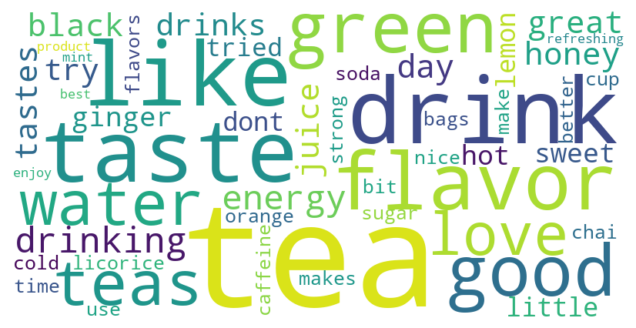

In [186]:
get_wordcloud(0)

**Topic 1: Teas and Beverages**
- **Supporting Evidence:**
    - **Keywords Identified:** 'tea,' 'green,' 'black,' 'soda,' 'drink,' and 'honey.'
    - These words strongly support the interpretation that the topic is centered around tea and beverages. The presence of terms like 'green' and 'black' directly reference common types of tea, while 'soda' and 'drink' suggest a broader category of beverages.
    - **Tea and Additions:** Words like 'honey' and 'lemon' point to common additives used with tea, while words like 'cold' and 'hot' reinforcing the idea that this topic relates not just to tea itself but also to popular ways of consuming it (e.g., sweetened or with other flavors, hot or cold).
    - **Beverage Variety:** The inclusion of 'soda' suggests that the topic may also be touching on broader beverage preferences. 
    - **Licorice Reference**: While the word 'licorice' may initially seem out of place in a discussion about teas and beverages, it could point to specific tea types such as licorice root tea or reflect flavor profiles that people associate with licorice, which is commonly found in herbal teas.